# Text Classification Based on Transformer Block

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import time

## 1）Read Data

In [0]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size,skip_top=1,maxlen=maxlen)

In [0]:
word_index = keras.datasets.imdb.get_word_index()

In [0]:
index_word = {index:word for (word,index) in word_index.items()}

In [0]:
def index_to_word(indexs):
    words = " ".join([index_word[index] for index in indexs])
    return words


In [6]:
# Inspecting some of the text
for i in range(3):
    print("Text #",i+1)
    print(index_to_word(x_train[i]))
    print()

Text # 1
the thought solid thought senator do making to is spot nomination assumed while he of jack in where picked as getting on was did hands fact characters to always life thrillers not as me can't in at are br of sure your way of little it strongly random to view of love it so principles of guy it used producer of where it of here icon film of outside to don't all unique some like of direction it if out her imagination below keep of queen he diverse to makes this stretch stefan of solid it thought begins br senator machinations budget worthwhile though ok brokedown awaiting for ever better were and diverse for budget look kicked any to of making it out and follows for effects show to show cast this family us scenes more it severe making senator to and finds tv tend to of emerged these thing wants but and an beckinsale cult as it is video do you david see scenery it in few those are of ship for with of wild to one is very work dark they don't do dvd with those them

Text # 2
the as 

## 2) Text Preprocessing

#### 1) Padding

In [7]:
tf.keras.preprocessing.sequence.pad_sequences(x_train,padding='post',maxlen=maxlen)

array([[   1,  194, 1153, ...,    0,    0,    0],
       [   1,   14,   47, ...,    0,    0,    0],
       [   1,  249, 1323, ...,    0,    0,    0],
       ...,
       [   1,  118, 2362, ...,    0,    0,    0],
       [   1,    6,  682, ...,    0,    0,    0],
       [   1,   13, 2684, ...,    0,    0,    0]], dtype=int32)

In [0]:
def get_max_length(tensor):
    return max(len(t) for t in tensor)

def padding(tensor):

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post',maxlen=maxlen)
    
    tensor = tf.convert_to_tensor(tensor)
    return tensor

In [0]:
input_tensor_train = padding(x_train)

output_tensor_train = tf.convert_to_tensor(y_train,dtype=tf.float32)

In [10]:
input_tensor_train.shape,output_tensor_train.shape

(TensorShape([25000, 200]), TensorShape([25000]))

In [0]:

input_tensor_val = padding(x_val)
output_tensor_val = tf.convert_to_tensor(y_val,dtype=tf.float32)

In [12]:
input_tensor_val.shape,output_tensor_val.shape

(TensorShape([3913, 200]), TensorShape([3913]))

#### 2) DataSet Creating

In [13]:
BUFFER_SIZE = len(x_train)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, output_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 200]), TensorShape([64]))

In [14]:
example_input_batch

<tf.Tensor: shape=(64, 200), dtype=int32, numpy=
array([[    1,    14,   390, ...,     0,     0,     0],
       [    1,    13,   119, ...,     0,     0,     0],
       [    1,   198,    61, ...,     0,     0,     0],
       ...,
       [    1, 13907,   174, ...,     0,     0,     0],
       [    1,   112,    15, ...,     0,     0,     0],
       [    1,    12,   127, ...,     0,     0,     0]], dtype=int32)>

In [15]:
example_target_batch

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

## 3) Transformer

<img src="https://tensorflow.google.cn/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

##### (1 )Embedding and Positional encoding  Layers

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [0]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [0]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [0]:
class EmbeddingAndPosEncoder(tf.keras.layers.Layer):
    def __init__(self,vocab_size,d_model):
        super(EmbeddingAndPosEncoder,self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=d_model)
        
    def call(self,x):
        x = self.embedding(x)
        seq_length = x.shape[1]
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        posencode_out = positional_encoding(seq_length,self.d_model)
        out = x+posencode_out
        return out 

In [0]:
embedding_dim = 512

In [0]:
EmbedAndPosEncoderLayer = EmbeddingAndPosEncoder(vocab_size=vocab_size,d_model=embedding_dim)

In [0]:
embedding_out = EmbedAndPosEncoderLayer(example_input_batch)

In [22]:
embedding_out.shape

TensorShape([64, 200, 512])

##### (2 ) Multi-Head Attention Layers

<img src="https://tensorflow.google.cn/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [0]:
def scaled_dot_product_attention(q, k, v):

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

<img src="https://tensorflow.google.cn/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):

        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [0]:
MultiHeadAttentionLayer = MultiHeadAttention(512,8)

In [0]:
v,k,q = embedding_out,embedding_out,embedding_out

In [0]:
Attention,Weights = MultiHeadAttentionLayer(v,k,q)

In [28]:
Attention.shape,Weights.shape

(TensorShape([64, 200, 512]), TensorShape([64, 8, 200, 200]))

#### (3) Point wise feed forward and add&Norm Layer

In [0]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

#### (4) Encoder Layers

In [0]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,rate):
        super(Encoder,self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.ffn = point_wise_feed_forward_network(d_model,dff)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.normLayer1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.normLayer2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
    def call(self,x,training):
        ### attention
        attn_output,attentionWeight = self.mha(x,x,x)
        ### add&Norm
        attn_output = self.dropout1(attn_output,training=training)
        out1 = self.normLayer1(attn_output+x)
        
        out2 = self.ffn(out1)
        out2 = self.dropout2(out2,training = training)
        out2 = self.normLayer2(out2+out1)
        
        return out2,attentionWeight


In [0]:
encoderLayer = Encoder(512,8,1024,0.1)

In [0]:
sampleEncderOutput,sampleAttentionWeight = encoderLayer(tf.random.uniform([64,200,512]),True)

#### (6) Transfomer

In [0]:
class Transformer(tf.keras.Model):
    def __init__(self,vocab_size,d_model,num_layers,num_heads,dff,rate,final_hidden_units,num_classes):
        super(Transformer, self).__init__()
        self.d_model = d_model
        
        self.embedAndPosEncoderLayer = EmbeddingAndPosEncoder(vocab_size,d_model)
        self.enc_layers = [Encoder(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.globalPooling= tf.keras.layers.GlobalAveragePooling1D()
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dense = tf.keras.layers.Dense(final_hidden_units,activation="relu")
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.final_layer = tf.keras.layers.Dense(num_classes,activation="softmax")
        

    def call(self,inp,training):
        attention_weights = []
        
        x = self.embedAndPosEncoderLayer(inp)
        
        for encoderLayer in self.enc_layers:
            x,attentionweight = encoderLayer(x,training)
            attention_weights.append(attentionweight)
        
        x = self.globalPooling(x)
        x = self.dropout1(x,training)
        x = self.dense(x)
        x = self.dropout2(x,training)

        final_output = self.final_layer(x)

        return final_output,attention_weights

In [0]:
sample_transformer = Transformer(vocab_size=2000,d_model=512,num_layers=3,num_heads=8,dff=1024,rate=0.1,final_hidden_units=64,num_classes=2)

In [0]:
sample_output,sample_attentionWeight = sample_transformer(tf.random.uniform((64, 62)),True)

In [36]:
sample_output.shape

TensorShape([64, 2])

#### (7) hyperparameters

In [0]:
num_layers = 2
d_model = 128
final_hidden_units = 64
dff = 512
num_heads = 8
vocab_size = vocab_size
dropout_rate = 0.1
num_classes = 2

In [0]:
text_classifer = Transformer(vocab_size=vocab_size,d_model=d_model,num_layers=num_layers,num_heads=num_heads,
                             dff=dff,rate=dropout_rate,final_hidden_units=final_hidden_units,num_classes=num_classes)

In [0]:
inputs = keras.layers.Input(shape=(maxlen,))

In [0]:
outputs,attention_weight = text_classifer(inputs,True)

In [0]:
model = keras.Model(inputs = inputs,outputs = outputs)

In [0]:
# model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
# history = model.fit(
#     input_tensor_train.numpy(), output_tensor_train.numpy(), batch_size=32, epochs=10, validation_data=(input_tensor_val.numpy() , output_tensor_val.numpy())
# )


#### (8) Optimizer

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -0.8)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

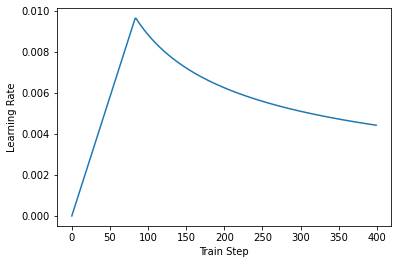

In [43]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(400, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [0]:
learning_rate = CustomSchedule(d_model)

In [45]:
learning_rate

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

#### (9) Loss and metrics¶

In [0]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction='auto')

In [48]:
example_target_batch.shape

TensorShape([64])

In [49]:
sample_output.shape

TensorShape([64, 2])

In [50]:
loss_function(example_target_batch,sample_output)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9165926>

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [0]:
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='val_accuracy')

#### (10) Training

In [53]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(text_classifer=text_classifer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [0]:
EPOCHS = 10

In [0]:
training = True 

In [56]:
example_input_batch

<tf.Tensor: shape=(64, 200), dtype=int32, numpy=
array([[    1,    14,   390, ...,     0,     0,     0],
       [    1,    13,   119, ...,     0,     0,     0],
       [    1,   198,    61, ...,     0,     0,     0],
       ...,
       [    1, 13907,   174, ...,     0,     0,     0],
       [    1,   112,    15, ...,     0,     0,     0],
       [    1,    12,   127, ...,     0,     0,     0]], dtype=int32)>

In [0]:
testing = False

In [58]:
input_tensor_val[:64,]

<tf.Tensor: shape=(64, 200), dtype=int32, numpy=
array([[   1,    4, 2026, ...,    0,    0,    0],
       [   1,   13, 2488, ...,    0,    0,    0],
       [   1,    4,   65, ...,    0,    0,    0],
       ...,
       [   1,   51,   70, ...,    0,    0,    0],
       [   1,   39,    4, ...,    0,    0,    0],
       [   1,  112,    6, ...,    0,    0,    0]], dtype=int32)>

In [0]:
predictions_val, _ = text_classifer(input_tensor_val[:64,],testing)

In [0]:
# train_step_signature = [
#     tf.TensorSpec(shape=(BATCH_SIZE, None), dtype=tf.int32),
#     tf.TensorSpec(shape=(BATCH_SIZE, None), dtype=tf.int32),
#     tf.TensorSpec(shape=(BATCH_SIZE, None), dtype=tf.int32),
#     tf.TensorSpec(shape=(BATCH_SIZE, None), dtype=tf.int32),
# ]

@tf.function
def train_step(inp, tar):
    with tf.GradientTape() as tape:
        predictions, _ = text_classifer(inp,True)
        loss = loss_function(tar, predictions)
        
    gradients = tape.gradient(loss, text_classifer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, text_classifer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar, predictions)

In [0]:
def val_step(inp_val,tar_val):
    predictions_val, _ = text_classifer(inp_val,False)
    loss_val = loss_function(tar_val, predictions_val)
    
    val_loss(loss_val)
    val_accuracy(tar_val,predictions_val)
    

In [62]:
input_tensor_val

<tf.Tensor: shape=(3913, 200), dtype=int32, numpy=
array([[   1,    4, 2026, ...,    0,    0,    0],
       [   1,   13, 2488, ...,    0,    0,    0],
       [   1,    4,   65, ...,    0,    0,    0],
       ...,
       [   1,   13, 1408, ...,    0,    0,    0],
       [   1,   11,  119, ...,    0,    0,    0],
       [   1,    6,   52, ...,    0,    0,    0]], dtype=int32)>

In [63]:
output_tensor_val

<tf.Tensor: shape=(3913,), dtype=float32, numpy=array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)>

In [0]:
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, output_tensor_val)).shuffle(len(input_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [65]:
next(iter(val_dataset))[1]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)>

In [66]:
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()

    val_loss.reset_states()
    val_accuracy.reset_states()


    for (batch, (inp, tar)) in enumerate(dataset):
        
        train_step(inp, tar)
        
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Traing Loss {:.4f} Traing Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result(), ))


    for (val_inp,val_tar) in val_dataset:
        val_step(val_inp,val_tar)
    

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

    print ('Epoch {} Training Loss {:.4f} Training Accuracy {:.4f} Val Loss {:.4f} Val Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result(),
                                                val_loss.result(),
                                                val_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Traing Loss 0.2706 Traing Accuracy 0.8594
Epoch 1 Batch 50 Traing Loss 0.2091 Traing Accuracy 0.9222
Epoch 1 Batch 100 Traing Loss 0.2181 Traing Accuracy 0.9172
Epoch 1 Batch 150 Traing Loss 0.2205 Traing Accuracy 0.9153
Epoch 1 Batch 200 Traing Loss 0.2256 Traing Accuracy 0.9124
Epoch 1 Batch 250 Traing Loss 0.2300 Traing Accuracy 0.9116
Epoch 1 Batch 300 Traing Loss 0.2310 Traing Accuracy 0.9110
Epoch 1 Batch 350 Traing Loss 0.2328 Traing Accuracy 0.9095
Epoch 1 Training Loss 0.2341 Training Accuracy 0.9082 Val Loss 0.3929 Val Accuracy 0.8404
Time taken for 1 epoch: 22.49802851676941 secs

Epoch 2 Batch 0 Traing Loss 0.1722 Traing Accuracy 0.9062
Epoch 2 Batch 50 Traing Loss 0.2119 Traing Accuracy 0.9213
Epoch 2 Batch 100 Traing Loss 0.2218 Traing Accuracy 0.9148
Epoch 2 Batch 150 Traing Loss 0.2200 Traing Accuracy 0.9136
Epoch 2 Batch 200 Traing Loss 0.2231 Traing Accuracy 0.9132
Epoch 2 Batch 250 Traing Loss 0.2255 Traing Accuracy 0.9125
Epoch 2 Batch 300 Traing Los